<a href="https://www.kaggle.com/code/thesardauna/3mtt-capstone-project-by-shamsuddeen-abdulazeez?scriptVersionId=212035611" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
!pip install dash

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 51.9 MB/s eta 0:00:00


In [2]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.arima.model import ARIMA
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, mean_absolute_error, mean_squared_error
import dash
from dash import dcc, html, Input, Output
import plotly.express as px

In [3]:
# Step 1: Load and Preprocess Data
def load_and_preprocess_data():
    try:
        # Load datasets
        covid_data = pd.read_csv('/kaggle/input/corona-virus-report/covid_19_clean_complete.csv')
        worldometer_data = pd.read_csv('/kaggle/input/corona-virus-report/worldometer_data.csv')
        full_grouped_data = pd.read_csv('/kaggle/input/corona-virus-report/full_grouped.csv')
        country_wise_latest = pd.read_csv('/kaggle/input/corona-virus-report/country_wise_latest.csv')

        # Standardize country names
        country_mapping = {
            'USA': 'US', 'UK': 'United Kingdom', 'UAE': 'United Arab Emirates',
            'S. Korea': 'South Korea', 'Ivory Coast': "Cote d'Ivoire",
            'Myanmar': 'Burma', 'CAR': 'Central African Republic',
            'DRC': 'Congo (Kinshasa)', 'Congo': 'Congo (Brazzaville)',
            'Saint Vincent Grenadines': 'Saint Vincent and the Grenadines',
            'Taiwan': 'Taiwan*'
        }
        for df in [worldometer_data, full_grouped_data, country_wise_latest]:
            df['Country/Region'] = df['Country/Region'].replace(country_mapping)

        # Merge datasets with unique suffixes
        merged_data = covid_data.merge(
            worldometer_data, on='Country/Region', how='left', suffixes=('', '_worldometer'))
        merged_data = merged_data.merge(
            full_grouped_data, on=['Country/Region', 'Date'], how='left', suffixes=('', '_grouped'))
        merged_data = merged_data.merge(
            country_wise_latest, on='Country/Region', how='left', suffixes=('', '_latest'))

        # Drop duplicate columns if necessary
        duplicate_columns = ['WHO Region_worldometer', 'WHO Region_grouped', 'WHO Region_latest']
        merged_data = merged_data.loc[:, ~merged_data.columns.isin(duplicate_columns)]

        # Handle missing values
        merged_data.ffill(inplace=True)
        merged_data.fillna(0, inplace=True)

        # Convert 'Date' to datetime
        merged_data['Date'] = pd.to_datetime(merged_data['Date'])

        return merged_data
    except Exception as e:
        print(f"Error loading data: {e}")
        return None

data = load_and_preprocess_data()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 49068 entries, 0 to 49067
Data columns (total 44 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   Province/State          49068 non-null  object        
 1   Country/Region          49068 non-null  object        
 2   Lat                     49068 non-null  float64       
 3   Long                    49068 non-null  float64       
 4   Date                    49068 non-null  datetime64[ns]
 5   Confirmed               49068 non-null  int64         
 6   Deaths                  49068 non-null  int64         
 7   Recovered               49068 non-null  int64         
 8   Active                  49068 non-null  int64         
 9   WHO Region              49068 non-null  object        
 10  Continent               49068 non-null  object        
 11  Population              49068 non-null  float64       
 12  TotalCases              49068 non-null  float6

/opt/conda/lib/python3.10/site-packages/pandas/core/nanops.py:1016: RuntimeWarning: invalid value encountered in subtract
  sqr = _ensure_numeric((avg - values) ** 2)


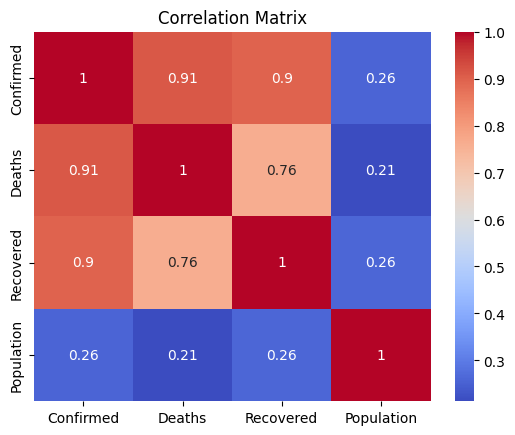

In [4]:
# Step 2: Exploratory Data Analysis
def analyze_data(df):
    print(df.info())
    print("Missing Values:\n", df.isnull().sum())
    print(df.describe())

    # Correlation matrix
    corr_matrix = df[['Confirmed', 'Deaths', 'Recovered', 'Population']].corr()
    sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
    plt.title('Correlation Matrix')
    plt.show()

if data is not None:
    analyze_data(data)

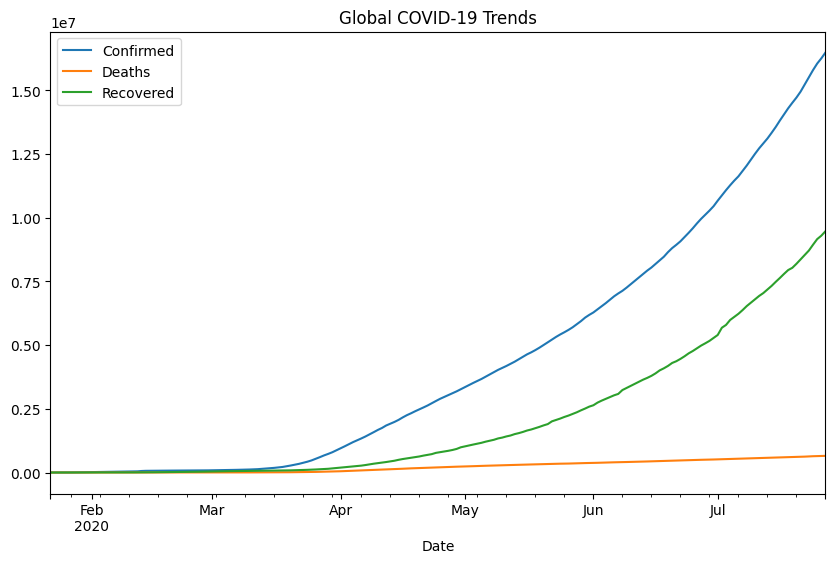

/opt/conda/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/opt/conda/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/opt/conda/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/opt/conda/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/opt/conda/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Che

                               SARIMAX Results                                
Dep. Variable:              Confirmed   No. Observations:                  150
Model:                 ARIMA(2, 1, 2)   Log Likelihood               -1556.844
Date:                Mon, 09 Dec 2024   AIC                           3123.689
Time:                        10:26:48   BIC                           3138.709
Sample:                    01-22-2020   HQIC                          3129.791
                         - 06-19-2020                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.0595      0.292      3.624      0.000       0.487       1.632
ar.L2         -0.0595      0.289     -0.206      0.837      -0.626       0.507
ma.L1         -0.2069      0.286     -0.723      0.4

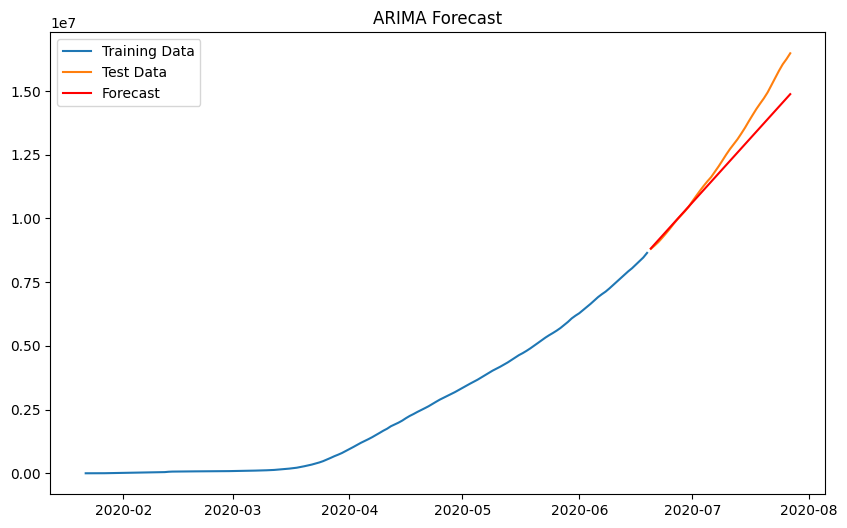

In [5]:
# Step 3: Time-Series Analysis
def time_series_analysis(df):
    global_trends = df.groupby('Date')[['Confirmed', 'Deaths', 'Recovered']].sum()
    global_trends.plot(figsize=(10, 6), title='Global COVID-19 Trends')
    plt.show()

    # ARIMA model
    time_series = global_trends['Confirmed']
    train_size = int(len(time_series) * 0.8)
    train, test = time_series[:train_size], time_series[train_size:]

    # Fit ARIMA model
    model = ARIMA(train, order=(2, 1, 2))
    model_fit = model.fit()
    print(model_fit.summary())

    # Forecast
    forecast = model_fit.forecast(steps=len(test))
    mae = mean_absolute_error(test, forecast)
    rmse = np.sqrt(mean_squared_error(test, forecast))
    print(f"MAE: {mae}, RMSE: {rmse}")

    # Plot results
    plt.figure(figsize=(10, 6))
    plt.plot(train.index, train, label='Training Data')
    plt.plot(test.index, test, label='Test Data')
    plt.plot(test.index, forecast, label='Forecast', color='red')
    plt.legend()
    plt.title('ARIMA Forecast')
    plt.show()

if data is not None:
    time_series_analysis(data)

In [6]:
consolidated_data = data

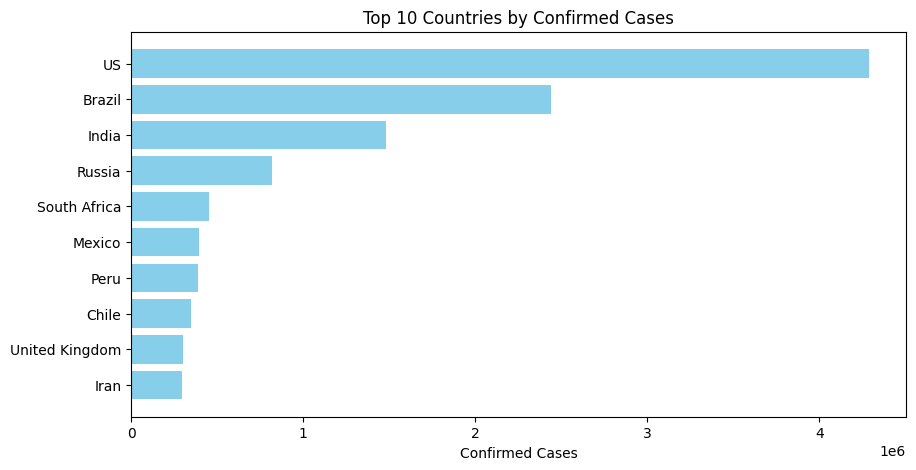

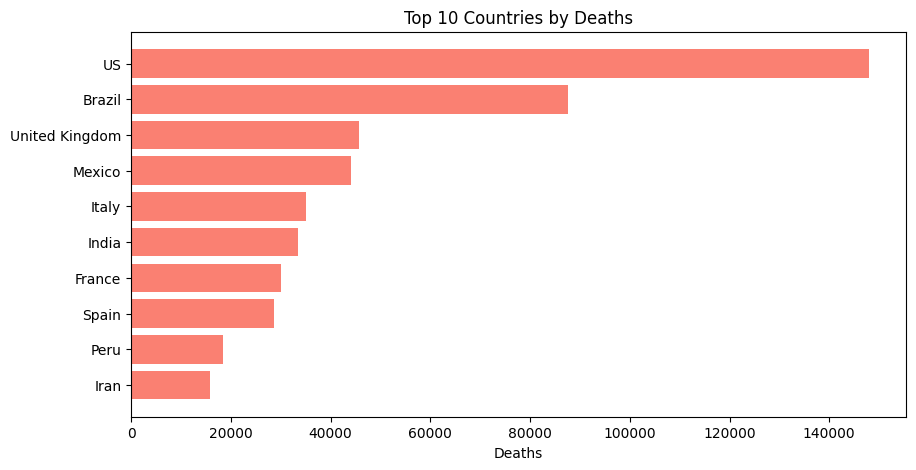

In [7]:
# Group by 'Country/Region' and get the latest counts (replace NaN with 0)
latest_data = consolidated_data.groupby('Country/Region')[['Confirmed', 'Deaths', 'Recovered']].max().fillna(0)

# Top 10 countries by confirmed cases
top_10_cases = latest_data.nlargest(10, 'Confirmed')
top_10_deaths = latest_data.nlargest(10, 'Deaths')

# Plot top 10 countries by confirmed cases and deaths
plt.figure(figsize=(10, 5))
plt.barh(top_10_cases.index, top_10_cases['Confirmed'], color='skyblue')
plt.xlabel('Confirmed Cases')
plt.title('Top 10 Countries by Confirmed Cases')
plt.gca().invert_yaxis()
plt.show()

plt.figure(figsize=(10, 5))
plt.barh(top_10_deaths.index, top_10_deaths['Deaths'], color='salmon')
plt.xlabel('Deaths')
plt.title('Top 10 Countries by Deaths')
plt.gca().invert_yaxis()
plt.show()


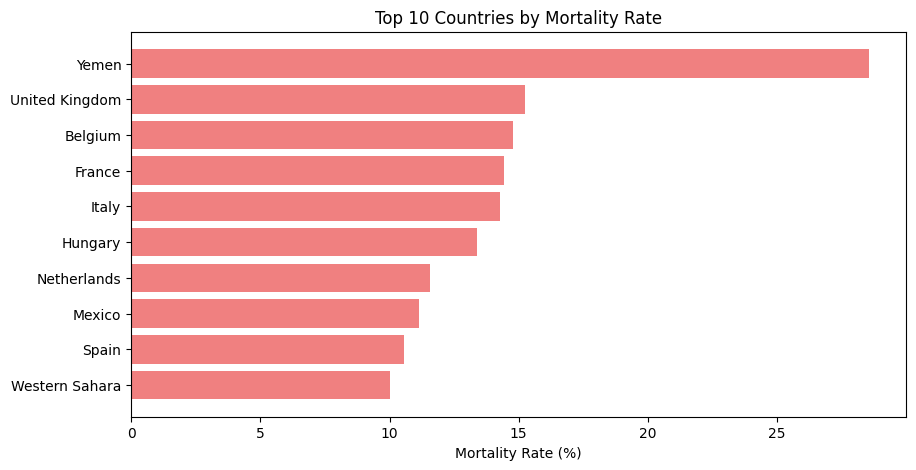

In [8]:
# Mortality and recovery rates
latest_data['Mortality Rate'] = (latest_data['Deaths'] / latest_data['Confirmed']) * 100
latest_data['Recovery Rate'] = (latest_data['Recovered'] / latest_data['Confirmed']) * 100

# Plotting top 10 countries by mortality rate
top_10_mortality = latest_data.nlargest(10, 'Mortality Rate')
plt.figure(figsize=(10, 5))
plt.barh(top_10_mortality.index, top_10_mortality['Mortality Rate'], color='lightcoral')
plt.xlabel('Mortality Rate (%)')
plt.title('Top 10 Countries by Mortality Rate')
plt.gca().invert_yaxis()
plt.show()


In [9]:
# Step 4: Classification Models
def classification_models(df):
    # Prepare target variable
    df['Mortality_Rate'] = df['Deaths'] / df['Confirmed']
    df['High_Mortality'] = (df['Mortality_Rate'] > 0.05).astype(int)

    features = ['Confirmed', 'Recovered', 'Population', 'Active']
    X = df[features].fillna(0)
    y = df['High_Mortality']

    # Split data
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Logistic Regression
    logreg = LogisticRegression()
    logreg.fit(X_train, y_train)
    y_pred_logreg = logreg.predict(X_test)
    print("Logistic Regression Report:")
    print(classification_report(y_test, y_pred_logreg))

    # Random Forest
    rf = RandomForestClassifier()
    rf.fit(X_train, y_train)
    y_pred_rf = rf.predict(X_test)
    print("Random Forest Report:")
    print(classification_report(y_test, y_pred_rf))

    # XGBoost
    xgb = XGBClassifier(eval_metric='logloss', random_state=42)
    xgb.fit(X_train, y_train)
    y_pred_xgb = xgb.predict(X_test)
    print("XGBoost Report:")
    print(classification_report(y_test, y_pred_xgb))

if data is not None:
    classification_models(data)

Logistic Regression Report:
              precision    recall  f1-score   support

           0       0.99      1.00      1.00      8411
           1       1.00      0.96      0.98      1403

    accuracy                           0.99      9814
   macro avg       1.00      0.98      0.99      9814
weighted avg       0.99      0.99      0.99      9814

Random Forest Report:
              precision    recall  f1-score   support

           0       0.99      1.00      0.99      8411
           1       0.98      0.95      0.97      1403

    accuracy                           0.99      9814
   macro avg       0.99      0.98      0.98      9814
weighted avg       0.99      0.99      0.99      9814

XGBoost Report:
              precision    recall  f1-score   support

           0       0.99      1.00      0.99      8411
           1       0.98      0.93      0.95      1403

    accuracy                           0.99      9814
   macro avg       0.98      0.96      0.97      9814
weighted

In [10]:

# Step 5: Interactive Dashboard
app = dash.Dash(__name__)
app.title = "COVID-19 Dashboard"

app.layout = html.Div([
    html.H1("COVID-19 Interactive Dashboard", style={'text-align': 'center'}),
    dcc.Dropdown(
        id='country_dropdown',
        options=[{'label': country, 'value': country} for country in data['Country/Region'].unique()],
        value='Global',
        style={'width': '50%'}
    ),
    dcc.Graph(id='time_series_plot'),
    dcc.Graph(id='global_map')
])

@app.callback(
    Output('time_series_plot', 'figure'),
    Input('country_dropdown', 'value')
)
def update_time_series(selected_country):
    if selected_country == 'Global':
        filtered_data = data.groupby('Date').sum().reset_index()
    else:
        filtered_data = data[data['Country/Region'] == selected_country]
    fig = px.line(filtered_data, x='Date', y=['Confirmed', 'Deaths', 'Recovered'],
                  title=f'COVID-19 Cases in {selected_country}')
    return fig

@app.callback(
    Output('global_map', 'figure'),
    Input('country_dropdown', 'value')
)
def update_global_map(_):
    latest_data = data[data['Date'] == data['Date'].max()]
    fig = px.choropleth(latest_data, locations="Country/Region", locationmode="country names",
                        color="Confirmed", hover_name="Country/Region",
                        color_continuous_scale="Viridis")
    return fig

if __name__ == '__main__':
    app.run_server(debug=True)
